In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os
import pandas as pd

#import utils.make_density_map as mdm
import utils.make_density_map_charles as mdm

In [2]:
def rescale_and_invcolor(img, inv_color, rescale):
    if inv_color == 1:
        img[img > 0.] = 1. - img[img > 0.]
    if rescale == 1:
        minn, maxx = np.min(img[img>0]), np.max(img[img>0])
        low, hi = 0.1*255, 1*255                                        #low, hi rescaling values (normed to 255)
        img[img>0] = low + (img[img>0] - minn)*(hi - low)/(maxx - minn) #linear re-scaling
    return img.astype(np.float32)

def load_target(f, img):
    minpix, maxpix = 2, 100                          #minimum pixels required for a crater to register in an image
    csv = pd.read_csv(f)
    csv = csv[(csv['Diameter (pix)'] < maxpix) & (csv['Diameter (pix)'] > minpix)]
    #target = mdm.make_mask(csv, img, binary=True, truncate=True, rings=True)
    #target = mdm.make_circlering_mask(csv, img, binary=True, truncate=True)
    
    rw = -1    #-1 = ringwidth is proportional to radius
    r_dec = 2  #decrease radius of csv ground truth circles for better matching
    target = mdm.make_mask(csv, img, binary=True, rings=True, ringwidth=rw, r_dec=r_dec, truncate=True)
    return target

In [10]:
path = "datasets/rings/Train_caffe_targets/"
files = glob.glob('%s*_invcol0.npy'%path);

invcolor, rescale = 0, 1
caffe_thresh, newGT_thresh = 0.1, 0.1

data, caffe_bin, origGT, newGT, caffe_inv0, caffe_inv1 = [], [], [], [], [], []
for f in files:
    name = os.path.basename(f).split('_invcol0.npy')[0]
    d = cv2.imread("datasets/rings/Train_rings/%s.png"%name)/255.
    d = rescale_and_invcolor(d, invcolor, rescale)
    caffeinv0 = np.load(f)
    caffeinv1 = np.load("%sinvcol1.npy"%f.split('invcol0.npy')[0])
    
    caffe_bin0 = caffeinv0.copy()
    caffe_bin1 = caffeinv1.copy()
    caffe_bin0[caffe_bin0 >= caffe_thresh] = 1; caffe_bin0[caffe_bin0 < caffe_thresh] = 0
    caffe_bin1[caffe_bin1 >= caffe_thresh] = 1; caffe_bin1[caffe_bin1 < caffe_thresh] = 0
    
    caffe_binary = caffe_bin1
    #caffe_binary = caffe_bin0 + caffe_bin1

    gt = load_target("datasets/rings/Train_rings/%s.csv"%name, d)
    gt_new = gt*caffe_binary
    gt_new[gt_new > newGT_thresh] = 1
    gt_new[gt_new <= newGT_thresh] = 0
    data.append(d); caffe_bin.append(caffe_binary); origGT.append(gt); newGT.append(gt_new); 
    caffe_inv0.append(caffeinv0); caffe_inv1.append(caffeinv1)

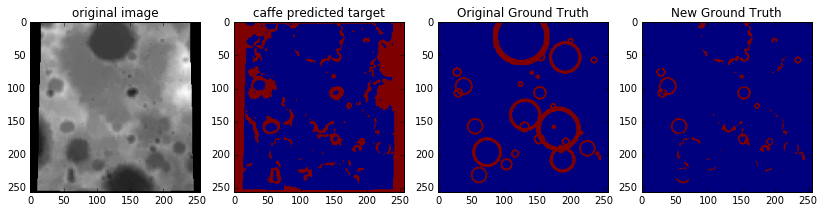

In [11]:
i=5

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[14, 6])
ax1.imshow(data[i]/255.)
ax2.imshow(caffe_bin[i])   #caffe_bin
ax3.imshow(origGT[i])
ax4.imshow(newGT[i])
ax1.set_title("original image")
ax2.set_title("caffe predicted target")
ax3.set_title("Original Ground Truth")
ax4.set_title("New Ground Truth")
plt.savefig("output_dir/images/caffe_targets_%d"%i)

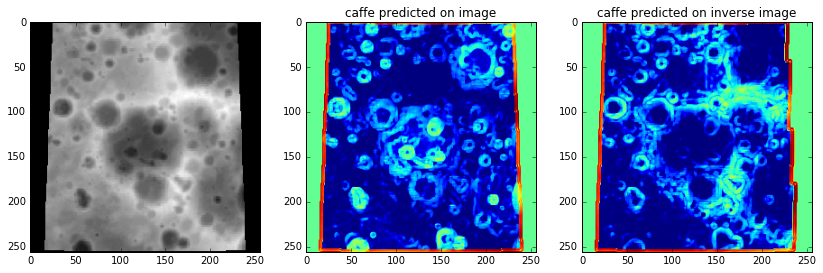

In [8]:
i=0
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=[14, 6])
ax1.imshow(data[i]/255.)
ax2.imshow(caffe_inv0[i])
ax3.imshow(caffe_inv1[i])
ax2.set_title('image')
ax2.set_title('caffe predicted on image')
ax3.set_title('caffe predicted on inverse image')
plt.savefig("output_dir/images/caffe_invcomp_%d"%i)

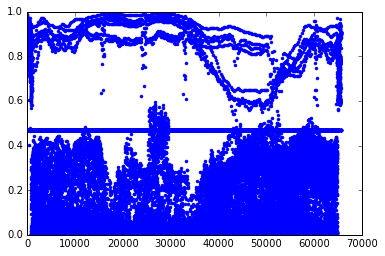

In [94]:
#plt.plot(data[i].reshape(256*256*3), '.')
plt.plot(edgedet[i].reshape(256*256), '.')